# HMC

In [1]:
import aesara
from aesara.tensor.random.utils import RandomStream
import aesara.tensor as aet
from aeppl.logpdf import logpdf
import numpy as np
import pymc3 as pm

import aehmc.hmc as hmc

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
NUM_INTEGRATION_STEPS = 10
STEP_SIZE = 0.0001
NUM_SAMPLES = 4_000

## The model: a simple linear regression

We consider a simple one-dimensional regression problem. To make it a little challenging, we create a dataset with 100,000 points:

In [3]:
X = np.random.normal(0, 1, size=(100_000,))
y = 3 * X + np.random.normal(0,1)

### PyMC3 implementation

In [4]:
with pm.Model() as pymc3_model:
    weights = pm.Normal("weights", mu=0, sigma=1)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    y_observed = pm.Normal(
        "y_observed",
        mu=X @ weights,
        sigma=noise,
        observed=y,
    )

### Aeppl implementation

We can implement the logpdf of this model directly using `aesara` and `aeppl`:

In [5]:
def aeppl_model_logpdf(position, X, y):
    weights = position[0]
    noise = position[1]
    l = 0
    l += aet.sum(logpdf(aet.random.normal(0, 1), weights))
    l += aet.sum(logpdf(aet.random.gamma(2, 1), noise))
    mu = aet.dot(X, weights)
    l += aet.sum(logpdf(aet.random.normal(mu, noise), y))
    return l

Let us condition the model on the data:

In [6]:
aeppl_loglikelihood = lambda position: aeppl_model_logpdf(position, aet.as_tensor(X), aet.as_tensor(y))

We can check that the loglikelihood returns the same values as the logpdf produced by PyMC3:

In [7]:
q = aet.vector("q")
aeppl_loglikelihood(q).eval({q: np.array([3, 10])})

array(-323256.47056254)

In [8]:
pymc3_model.fastlogp({'weights':3, 'noise_log__': np.log(10)})

array(-323254.16797744)

## Sampling with aehmc

`aehmc`'s HMC algorithm takes a potential function as an input, which here can be taken as minus the loglikelihood:

In [9]:
potential = lambda q: -aeppl_loglikelihood(q)

### Build the HMC kernel

The `hmc.kernel` function returns, given the parameters of the HMC algorithm (a random seed, the potential, the step size, inverse mass matrix and number of integration steps) returns a "kernel" which given a chain state returns a graph that computes the next chain state:

In [10]:
srng = RandomStream(seed=59)
inverse_mass_matrix = aet.as_tensor(np.array([1, 1]))
kernel = hmc.kernel(srng, potential, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

Let us compile this graph into a function:

In [11]:
q = aet.vector("q")
potential_energy = potential(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

next_step = kernel(q, potential_energy, potential_energy_grad)
kernel_fn = aesara.function((q,), next_step)

Let's execute it for one position:

In [12]:
kernel_fn(np.array([1., 3.]))

[array([1.01084087, 2.99503283]),
 array(235786.64172406),
 array([-22079.25441109,  10555.51460628])]

### Build the trajectory

We can also build a graph that computes the entire trajectory given the initial position and a number of samples, using aesara `scan` construct:

In [13]:
def build_trajectory_generator(srng, kernel_generator, potential_fn, num_samples):
    """Builds a function which, given an initial position, returns the full trajectory."""
    q = aet.vector("q")
    potential_energy = potential_fn(q)
    potential_energy_grad = aesara.grad(potential_energy, wrt=q)

    step_size = aet.scalar("step_size")
    inverse_mass_matrix = aet.vector("inverse_mass_matrix")
    num_integration_steps = aet.scalar("num_integration_steps", dtype="int32")

    kernel = kernel_generator(
        srng, potential_fn, step_size, inverse_mass_matrix, num_integration_steps
    )

    trajectory, updates = aesara.scan(
        fn=kernel,
        outputs_info=[
            {"initial": q},
            {"initial": potential_energy},
            {"initial": potential_energy_grad},
        ],
        n_steps=num_samples,
    )
    trajectory_generator = aesara.function(
        (q, step_size, inverse_mass_matrix, num_integration_steps),
        trajectory,
        updates=updates,
        profile=True
    )

    return trajectory_generator

We can now compile the function that generates the chain and execute it:

In [14]:
%%time
trajectory_generator = build_trajectory_generator(
    srng, hmc.kernel, potential, num_samples=NUM_SAMPLES
)

initial_position = np.array([1., 3.])
inverse_mass_matrix = np.array([1, 1])
position, *_ = trajectory_generator(initial_position, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

CPU times: user 16.7 s, sys: 92.3 ms, total: 16.8 s
Wall time: 17.3 s


Let us quickly check that the chain sampled correctly:

Text(0.5, 0, 'noise')

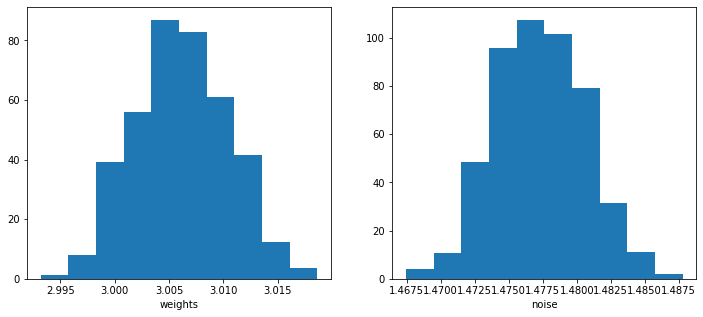

In [15]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.hist(position[1000:, 0], density=True)
ax1.set_xlabel("weights")
ax2.hist(position[1000:, 1], density=True)
ax2.set_xlabel("noise")

## Sampling with PyMC3

We are now ready to compare the performance of `aehmc`'s HMC kernel to that of PyMC3.

In [16]:
%%time
with pymc3_model:
    step = pm.step_methods.hmc.hmc.HamiltonianMC([weights, noise], path_length=NUM_INTEGRATION_STEPS, step_scale=STEP_SIZE)
    posterior = pm.sample(tune=0, draws=NUM_SAMPLES, step=[step], chains=1)

<timed exec>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [noise, weights]


Sampling 1 chain for 0 tune and 384 draw iterations (0 + 384 draws total) took 226 seconds.
The acceptance probability does not match the target. It is 0.9999081203429263, but should be close to 0.65. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 3min 46s, sys: 290 ms, total: 3min 46s
Wall time: 3min 47s


`aehmc`'s kernel is orders of magnitude faster than PyMC3's.

## Profiling `aehmc`'s generated trajectory

In [17]:
aesara.config.profile = True
aesara.config.profile_optimizer = True

In [18]:
trajectory_generator = build_trajectory_generator(
    srng, hmc.kernel, potential, num_samples=NUM_SAMPLES
)

In [19]:
trajectory_generator.profile.summary()

Function profiling
  Message: <ipython-input-13-6d3a9c0e6bd8>:24
  Time in 0 calls to Function.__call__: 0.000000e+00s
  Total compile time: 7.750485e-01s
    Number of Apply nodes: 44
    Aesara Optimizer time: 2.904701e-01s
       Aesara validate time: 2.713919e-03s
    Aesara Linker time (includes C, CUDA code generation/compiling): 0.4756960868835449s
       Import time 0.000000e+00s
       Node make_thunk time 4.746168e-01s
           Node forall_inplace,cpu,scan_fn}(TensorConstant{4000}, IncSubtensor{Set;:int64:}.0, IncSubtensor{InplaceSet;:int64:}.0, IncSubtensor{InplaceSet;:int64:}.0, RandomStateSharedVariable(<RandomState(MT19937) at 0x7F8E313C7640>), RandomStateSharedVariable(<RandomState(MT19937) at 0x7F8E313C7540>), inverse_mass_matrix, num_integration_steps, step_size, Elemwise{Composite{sqrt(reciprocal(i0))}}.0, InplaceDimShuffle{x}.0) time 4.592261e-01s
           Node Elemwise{Composite{(i0 - (i1 * i2))}}(TensorConstant{[-3.669986...70107078]}, TensorConstant{[-0.730944